In [97]:
import torch
import cv2
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.image as mpimg
import math

In [98]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        self.conv_layer = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.fc_layer1 = nn.Linear(50 * 50 * 32, 128)
        self.fc_layer2 = nn.Linear(128, 13)

    def forward(self, x):
        # input: 32x1x28x28 -> output: 32x32x26x26
        x = self.conv_layer(x)
        x = F.relu(x)

        # input: 32x32x26x26 -> output: 32x(32*26*26)
        x = x.flatten(start_dim = 1)

        # input: 32x(32*26*26) -> output: 32x128
        x = self.fc_layer1(x)
        x = F.relu(x)

        # input: 32x128 -> output: 32x10 (32 images, 13 classes)
        x = self.fc_layer2(x)
        out = F.softmax(x, dim=1)
        return out

In [99]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleModel()
model = model.to(device)

labels = ['blackbishop', 'blackking', 'blackknight', 'blackpawn', 'blackqueen', 'blackrook', 'nothing', 'whitebishop', 'whiteking', 'whiteknight', 'whitepawn', 'whitequeen', 'whiterook']
checkpoint = torch.load('./model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

transform = transforms.Compose([
    transforms.ToTensor()
    ])

In [100]:
def eval(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_image = image.copy()
    orig_image = cv2.resize(orig_image, (260, 260))

    # cv2.imshow('Result', orig_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    image = transform(image)

    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image.to(device))
    output_label = torch.topk(outputs, 1)
    pred_class = labels[int(output_label.indices)]

    return(pred_class)
    # print('prediction=', pred_class)


image = cv2.imread('./wking-modified.jpg')
eval(image)

'whiteking'

In [101]:
def classify_lines(lines):
    # print(lines)
    h=[]
    v=[]
    for i in range(lines.shape[0]):
        if(abs(lines[i][0][0]-lines[i][0][2]) < 100):
            h.append(lines[i])
        else:
            v.append(lines[i])

    return h, v
        # print(lines[i][0][0], lines[i][0][1], lines[i][0][2], lines[i][0][3])

def get_lines(lines_in):
    if cv2.__version__ < '3.0':
        return lines_in[0]
    return [l[0] for l in lines_in]

def merge_lines_pipeline_2(lines):
    super_lines_final = []
    super_lines = []
    min_distance_to_merge = 30
    min_angle_to_merge = 30
    
    for line in lines:
        create_new_group = True
        group_updated = False

        for group in super_lines:
            for line2 in group:
                if get_distance(line2, line) < min_distance_to_merge:
                    # check the angle between lines       
                    orientation_i = math.atan2((line[0][1]-line[1][1]),(line[0][0]-line[1][0]))
                    orientation_j = math.atan2((line2[0][1]-line2[1][1]),(line2[0][0]-line2[1][0]))

                    if int(abs(abs(math.degrees(orientation_i)) - abs(math.degrees(orientation_j)))) < min_angle_to_merge: 
                        #print("angles", orientation_i, orientation_j)
                        #print(int(abs(orientation_i - orientation_j)))
                        group.append(line)

                        create_new_group = False
                        group_updated = True
                        break
            
            if group_updated:
                break

        if (create_new_group):
            new_group = []
            new_group.append(line)

            for idx, line2 in enumerate(lines):
                # check the distance between lines
                if get_distance(line2, line) < min_distance_to_merge:
                    # check the angle between lines       
                    orientation_i = math.atan2((line[0][1]-line[1][1]),(line[0][0]-line[1][0]))
                    orientation_j = math.atan2((line2[0][1]-line2[1][1]),(line2[0][0]-line2[1][0]))

                    if int(abs(abs(math.degrees(orientation_i)) - abs(math.degrees(orientation_j)))) < min_angle_to_merge: 
                        #print("angles", orientation_i, orientation_j)
                        #print(int(abs(orientation_i - orientation_j)))

                        new_group.append(line2)

                        # remove line from lines list
                        #lines[idx] = False
            # append new group
            super_lines.append(new_group)
        
    
    for group in super_lines:
        super_lines_final.append(merge_lines_segments1(group))
    
    return super_lines_final

def merge_lines_segments1(lines, use_log=False):
    if(len(lines) == 1):
        return lines[0]
    
    line_i = lines[0]
    
    # orientation
    orientation_i = math.atan2((line_i[0][1]-line_i[1][1]),(line_i[0][0]-line_i[1][0]))
    
    points = []
    for line in lines:
        points.append(line[0])
        points.append(line[1])
        
    if (abs(math.degrees(orientation_i)) > 45) and abs(math.degrees(orientation_i)) < (90+45):
        
        #sort by y
        points = sorted(points, key=lambda point: point[1])
        
        if use_log:
            print("use y")
    else:
        
        #sort by x
        points = sorted(points, key=lambda point: point[0])
        
        if use_log:
            print("use x")
    
    return [points[0], points[len(points)-1]]

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
# https://stackoverflow.com/questions/32702075/what-would-be-the-fastest-way-to-find-the-maximum-of-all-possible-distances-betw
def lines_close(line1, line2):
    dist1 = math.hypot(line1[0][0] - line2[0][0], line1[0][0] - line2[0][1])
    dist2 = math.hypot(line1[0][2] - line2[0][0], line1[0][3] - line2[0][1])
    dist3 = math.hypot(line1[0][0] - line2[0][2], line1[0][0] - line2[0][3])
    dist4 = math.hypot(line1[0][2] - line2[0][2], line1[0][3] - line2[0][3])
    
    if (min(dist1,dist2,dist3,dist4) < 100):
        return True
    else:
        return False
    
def lineMagnitude (x1, y1, x2, y2):
    lineMagnitude = math.sqrt(math.pow((x2 - x1), 2)+ math.pow((y2 - y1), 2))
    return lineMagnitude
 
#Calc minimum distance from a point and a line segment (i.e. consecutive vertices in a polyline).
# https://nodedangles.wordpress.com/2010/05/16/measuring-distance-from-a-point-to-a-line-segment/
# http://paulbourke.net/geometry/pointlineplane/
def DistancePointLine(px, py, x1, y1, x2, y2):
    #http://local.wasp.uwa.edu.au/~pbourke/geometry/pointline/source.vba
    LineMag = lineMagnitude(x1, y1, x2, y2)
 
    if LineMag < 0.00000001:
        DistancePointLine = 9999
        return DistancePointLine
 
    u1 = (((px - x1) * (x2 - x1)) + ((py - y1) * (y2 - y1)))
    u = u1 / (LineMag * LineMag)
 
    if (u < 0.00001) or (u > 1):
        #// closest point does not fall within the line segment, take the shorter distance
        #// to an endpoint
        ix = lineMagnitude(px, py, x1, y1)
        iy = lineMagnitude(px, py, x2, y2)
        if ix > iy:
            DistancePointLine = iy
        else:
            DistancePointLine = ix
    else:
        # Intersecting point is on the line, use the formula
        ix = x1 + u * (x2 - x1)
        iy = y1 + u * (y2 - y1)
        DistancePointLine = lineMagnitude(px, py, ix, iy)
 
    return DistancePointLine

def get_distance(line1, line2):
    dist1 = DistancePointLine(line1[0][0], line1[0][1], 
                              line2[0][0], line2[0][1], line2[1][0], line2[1][1])
    dist2 = DistancePointLine(line1[1][0], line1[1][1], 
                              line2[0][0], line2[0][1], line2[1][0], line2[1][1])
    dist3 = DistancePointLine(line2[0][0], line2[0][1], 
                              line1[0][0], line1[0][1], line1[1][0], line1[1][1])
    dist4 = DistancePointLine(line2[1][0], line2[1][1], 
                              line1[0][0], line1[0][1], line1[1][0], line1[1][1])
    
    return min(dist1,dist2,dist3,dist4)

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

# someimage = './2D-Chessboard-and-Chess-Pieces-4/valid/lichess3986__kPrQKQbk-BRR1q11B-bQk11BNk-NrBqbrrb-qBpQNn1K-qn1qqnqB-K1pbQnBP-pKpRKrbK_png.rf.764a007ff332038a44e9fbb2a9aadbcd.jpg'
# someimage = './1_r6UCJiab1dAUJwdjKXTtoA.png'
# someimage = './2D-Chessboard-and-Chess-Pieces-4/train/lichess1815__BkqrBB1r-BqnBbKQp-NbkRnPrp-pBqkRq1B-RbkrRPKP-pQpKNkpN-kbPnKPBK-bprPBpRQ_png.rf.694738e2c406fdc7bac8376a15521411.jpg'
# someimage = './2D-Chessboard-and-Chess-Pieces-4/train/lichess0482__NKqNPQqQ-rrPrkpqR-1RKKQBqQ-NnknBrRk-NNQbBN1n-qPqKNpQN-BNNpqQPB-n1Rb1PnK_png.rf.30d1a1ec195d181a341cc33d941da378.jpg'
# someimage = './2D-Chessboard-and-Chess-Pieces-4/test/lichess3442__NrrNpPQ1-q1BNRQpP-PRKqbqnn-nqQNBQbN-kBQKQnQp-RBbQqkQR-bQp1NNpK-k1nkqrkq_png.rf.a212fcb70316e88c3a4713657d68a1d5.jpg'
# someimage = './2D-Chessboard-and-Chess-Pieces-4/valid/lichess0289__RqrQkRQN-KQbnPPPn-BqBB1npP-RBPRRPbp-rpK1kBRq-QQBpNBP1-NPQrNRnq-nNNkQrbP_png.rf.dc03d6959667daf88a96b4c111c65050.jpg'
# someimage = './2D-Chessboard-and-Chess-Pieces-4/valid/lichess3360__qKBRBQNR-QBbprkpR-KBqpNpnq-BrNKK1np-bNRbrBQQ-KBkP1KrN-bn1qppnB-KQqnPbQP_png.rf.5ba6bbc2774d54308dbaa3a150a1e953.jpg'
# someimage = './2D-Chessboard-and-Chess-Pieces-4/valid/lichess3735__11RKNnpQ-Brq1KrkN-RNbKkPQQ-QrKnrRRn-pRRBnQnp-BbqRbQ1B-K1NRBPRk-QK11P1Kr_png.rf.8503fe07372da49be62817b6b2f08b49.jpg'
# someimage = './2D-Chessboard-and-Chess-Pieces-4/valid/lichess0262__kQnRNkRq-PBNKRpqk-pqPbBrpb-kKp1qrNp-kKqNrKkn-RKRQQPrK-QQKkPb1B-rRnRRp1q_png.rf.930e9010cdc9dfc83a19fd4438b3e22d.jpg'
# someimage = './2D-Chessboard-and-Chess-Pieces-4/valid/lichess1096__BQbqNNnK-1RPrRbpq-rrRbnrqQ-bnKKbQQP-BpPQPRkQ-BPrPBbQR-pKkpn1pP-KKKrNq1r_png.rf.c59778da5a19a56c65a1f0064f880f79.jpg'
# someimage = './2D-Chessboard-and-Chess-Pieces-4/test/lichess0325__kbnbPBNB-RKppQrrP-qrqkQQ1N-qpKpbQbP-nqnBqpNp-NKNRRqpr-NrnqRknp-QBrnKbPQ_png.rf.f72f267a36c622be75ff5cd9ba4b8abc.jpg'
# someimage = './2D-Chessboard-and-Chess-Pieces-4/train/lichess2734__1P1nb1KB-RkbBrbbQ-K1kqpBRQ-rBRNrNKB-BrrnPKnN-KKPbQBpR-PPQkPqqN-111rKPqq_png.rf.90d7c1955e4512391a600eed86703acb.jpg'
# someimage = './2D-Chessboard-and-Chess-Pieces-4/test/lichess3722__R1RqNKBk-rbkRPKBR-bn1RKkQN-nQBqPKBN-RbQbqPqN-NQbRbqBB-qqKbRbQq-pbkbQ1KB_png.rf.b08719fb4203d190932321c1c4273417.jpg'
# someimage = './2D-Chessboard-and-Chess-Pieces-4/train/lichess2434__rPQkBP1k-QBQqqnkQ-nNnPRQPn-ppKNKKBq-NKrBqqpr-kbPRkBNP-PPqKKQ1N-pqQqK1p1_png.rf.651d48ef27b5dc7a7915b20a651f9490.jpg'
someimage = './test.png'

randomdir = random.choice(os.listdir('./2D-Chessboard-and-Chess-Pieces-4/'))
randomboard = random.choice(os.listdir('./2D-Chessboard-and-Chess-Pieces-4/' + randomdir))
# someimage = './2D-Chessboard-and-Chess-Pieces-4/' + randomdir + '/' + randomboard
print(someimage)

img_board = cv2.imread(someimage)
img_board = cv2.resize(img_board, (900, 900), interpolation=cv2.INTER_AREA)
img_board = cv2.blur(img_board, (3,3))

img_board = cv2.copyMakeBorder(img_board, 25, 25, 25, 25, cv2.BORDER_WRAP)
img_board_gray = cv2.cvtColor(img_board, cv2.COLOR_BGR2GRAY)

s = 2
kernel = np.ones((s, s), np.uint8)
img_board_gray_grad = cv2.morphologyEx(img_board_gray, cv2.MORPH_GRADIENT, kernel)

thresh = 10
im_bw = cv2.threshold(img_board_gray_grad, thresh, 255, cv2.THRESH_BINARY)[1]

# edges = cv2.Canny(im_bw,40,150,apertureSize = 7)
kernel = np.ones((3,3),np.uint8)
edges = cv2.dilate(im_bw,kernel,iterations = 3)

lines = cv2.HoughLinesP(image=edges, rho = 2, theta = np.pi/90, threshold=200, lines = np.array([]), minLineLength=850, maxLineGap=5)

# for line in get_lines(lines):
#     leftx, boty, rightx, topy = line
#     cv2.line(img_board, (leftx, boty), (rightx,topy), (0,0,255), 2) 

_lines = []
for _line in get_lines(lines):
    _lines.append([(_line[0], _line[1]),(_line[2], _line[3])])
    
# sort
_lines_x = []
_lines_y = []
for line_i in _lines:
    orientation_i = math.atan2((line_i[0][1]-line_i[1][1]),(line_i[0][0]-line_i[1][0]))
    if (abs(math.degrees(orientation_i)) > 45) and abs(math.degrees(orientation_i)) < (90+45):
        _lines_y.append(line_i)
    else:
        _lines_x.append(line_i)
        
_lines_x = sorted(_lines_x, key=lambda _line: _line[0][0])
_lines_y = sorted(_lines_y, key=lambda _line: _line[0][1])

merged_lines_x = merge_lines_pipeline_2(_lines_x)
merged_lines_y = merge_lines_pipeline_2(_lines_y)

merged_lines_all = []
merged_lines_all.extend(merged_lines_x)
merged_lines_all.extend(merged_lines_y)
print("process groups lines", len(_lines), len(merged_lines_all))
# for line in merged_lines_all:
#     cv2.line(img_board, (line[0][0], line[0][1]), (line[1][0],line[1][1]), (0,0,255), 2)

intersections = []
boardcorners = []

for horizontal in merged_lines_x:
    for vertical in merged_lines_y:
        intersections.append(line_intersection(horizontal, vertical))


prunedintersections = []
for intersection in intersections:
    if(not(intersection[0]<15 or intersection[1]>935 or intersection[0]>935 or intersection[1]<15)):
        prunedintersections.append(intersection)

intersections = prunedintersections
# print(prunedintersections)

smallest = 2000
topleft = intersections[0]
for intersection in intersections:
    if(intersection[0]+intersection[1]<smallest):
        smallest = intersection[0] + intersection[1]
        topleft = intersection
boardcorners.append([topleft[0], topleft[1]])

largest = 0
bottomright = intersections[0]
for intersection in intersections:
    if(intersection[0]+intersection[1]>largest):
        largest = intersection[0] + intersection[1]
        bottomright = intersection
boardcorners.append([bottomright[0], bottomright[1]])

topright = intersections[0]
for intersection in intersections:
    if((intersection[0]>topright[0]*0.9) and (intersection[1]<topright[1]*1.1)):
        topright = intersection
boardcorners.append([topright[0], topright[1]])

bottomleft = intersections[0]
for intersection in intersections:
    if((intersection[0]<bottomleft[0]*1.1) and (intersection[1]>bottomleft[1]*0.9)):
        bottomleft = intersection
boardcorners.append([bottomleft[0], bottomleft[1]])

print(boardcorners)

# for corner in boardcorners:
#     cv2.circle(img_board, (round(corner[0]), round(corner[1])), radius=4, color=(0,255,0), thickness=7)

m = cv2.getPerspectiveTransform(np.array([boardcorners[0], boardcorners[2], boardcorners[1], boardcorners[3]], np.float32), np.array([[0,0],[952,0],[952,952],[0,952]], np.float32))
img_board = cv2.warpPerspective(img_board, m, (952, 952))

# Show the result
cv2.imshow('Result', img_board)
cv2.waitKey(0)
cv2.destroyAllWindows()

./test.png
process groups lines 101 18
[[24.83674266941856, 19.366400840223246], [917.16989966778, 925.9664593252559], [923.7593324740008, 32.62764031046998], [17.202165423618908, 925.0181266232072]]


In [102]:
piecesarray = []
xcoord = 0
ycoord = 0
increment = 119

for i in range(0, 8, 1):
    ycoord=0
    for j in range(0, 8, 1):
        temp = img_board[xcoord:xcoord+119, ycoord:ycoord+119]
        temp = cv2.resize(temp, (52, 52))
        piecesarray.append(eval(temp))
        ycoord+=119
    xcoord+=119

print(piecesarray)


['blackrook', 'nothing', 'nothing', 'nothing', 'blackking', 'nothing', 'nothing', 'blackrook', 'blackpawn', 'blackpawn', 'nothing', 'blackbishop', 'nothing', 'blackpawn', 'blackpawn', 'blackpawn', 'nothing', 'nothing', 'nothing', 'nothing', 'blackpawn', 'nothing', 'nothing', 'nothing', 'nothing', 'nothing', 'nothing', 'blackpawn', 'blackknight', 'nothing', 'nothing', 'nothing', 'nothing', 'nothing', 'nothing', 'nothing', 'nothing', 'nothing', 'nothing', 'nothing', 'nothing', 'nothing', 'blackbishop', 'whitebishop', 'whitebishop', 'whiteknight', 'nothing', 'nothing', 'nothing', 'nothing', 'nothing', 'nothing', 'whitequeen', 'whitepawn', 'whitepawn', 'whitepawn', 'nothing', 'nothing', 'whitebishop', 'nothing', 'nothing', 'whitebishop', 'whiteking', 'nothing']


r3k2r/pp1b1ppp/4p3/3pn3/8/2bBBN2/4QPPP/2B2BK1


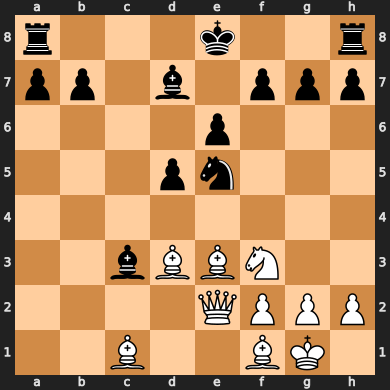

In [105]:
import chess
pos = ""

for i in range(0, 64, 1):
    if(piecesarray[i]=="blackrook"):
        pos+='r'
    elif(piecesarray[i]=="whiterook"):
        pos+='R'
    elif(piecesarray[i]=="blackbishop"):
        pos+='b'
    elif(piecesarray[i]=="whitebishop"):
        pos+='B'
    elif(piecesarray[i]=="blackknight"):
        pos+='n'
    elif(piecesarray[i]=="whiteknight"):
        pos+='N'
    elif(piecesarray[i]=="blackqueen"):
        pos+='q'
    elif(piecesarray[i]=="whitequeen"):
        pos+='Q'
    elif(piecesarray[i]=="blackking"):
        pos+='k'
    elif(piecesarray[i]=="whiteking"):
        pos+='K'
    elif(piecesarray[i]=="blackpawn"):
        pos+='p'
    elif(piecesarray[i]=="whitepawn"):
        pos+='P'
    elif(piecesarray[i]=="nothing"):
        pos+='1'
    if((i+1)%8==0 and i!=63):
        pos+='/'

FENpos = ""

counter=0
for i in pos:
    if(i=='1'):
        counter+=1
    else:
        # print(counter)
        if(counter!=0):
            FENpos+=str(counter)
        FENpos+=i
        counter=0
if(counter!=0):
    FENpos+=str(counter)

print(FENpos)

board = chess.Board(FENpos)
board